In [1]:
import torch
import requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt

# We'll be exploring a number of pipelines today!
from diffusers import (
    StableDiffusionPipeline,
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline,
    StableDiffusionDepth2ImgPipeline,
)


# We'll use a couple of demo images later in the notebook
def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")


# Download images for inpainting example
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

img_height = 512
img_width = 512

init_image = download_image(img_url).resize((img_height, img_width))
mask_image = download_image(mask_url).resize((img_height, img_width))

/home/jiuxia/libs/python/anaconda3/envs/comfyui/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
device = "cuda"
pipe = StableDiffusionPipeline.from_pretrained("/home/jiuxia/tmp/stable-diffusion-v1-5", dtype=torch.float16).to(device)

Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 18.77it/s]


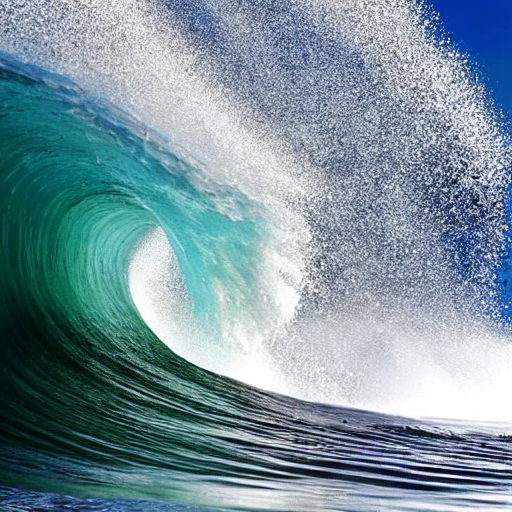

In [14]:
guidance_scale = 7.5
steps = 30
prompt = "beautiful picture of a wave breaking"
negative_prompt = "zoomed in, blurry, low quality"
generator = torch.Generator(device=device).manual_seed(0)

text_embeding = pipe._encode_prompt(prompt, device, 1, True, negative_prompt=negative_prompt)
latents = torch.randn(1, 4, 64, 64, device=device, generator=generator)
#对结果影响不大
latents *=pipe.scheduler.init_noise_sigma

pipe.scheduler.set_timesteps(steps, device)
for i, t in enumerate(pipe.scheduler.timesteps):

    latent_model_input = torch.cat([latents]*2)
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeding).sample
    
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

with torch.no_grad():
    image = pipe.decode_latents(latents)

pipe.numpy_to_pil(image)[0]

In [15]:
img2img_pipe = StableDiffusionImg2ImgPipeline.from_pretrained("/home/jiuxia/tmp/stable-diffusion-v1-5", dtype=torch.float16).to(device)

Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionImg2ImgPipeline and will be ignored.
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 17.66it/s]


100%|██████████| 40/40 [00:04<00:00,  9.05it/s]


Text(0.5, 1.0, 'Result')

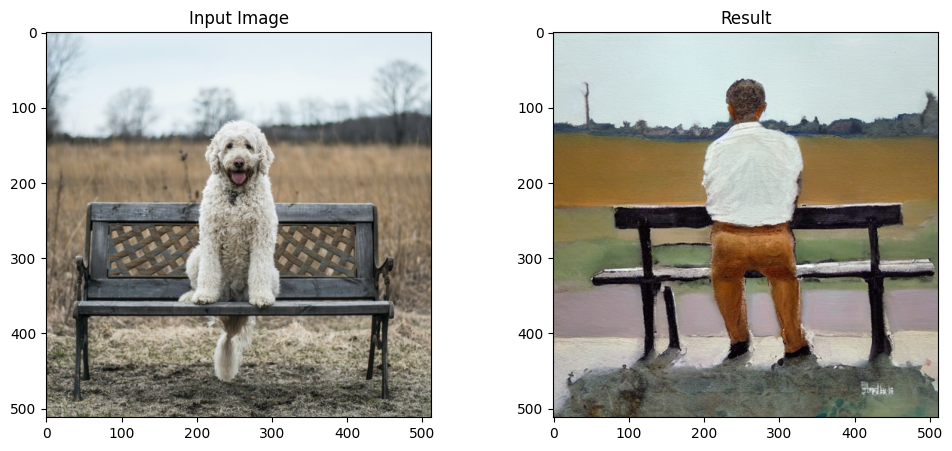

In [17]:
# Apply Img2Img
result_image = img2img_pipe(
    prompt="An oil painting of a man on a bench",
    image=init_image,  # The starting image
    strength=0.8,  # 0 for no change, 1.0 for max strength
).images[0]

# View the result
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(init_image)
axs[0].set_title("Input Image")
axs[1].imshow(result_image)
axs[1].set_title("Result")

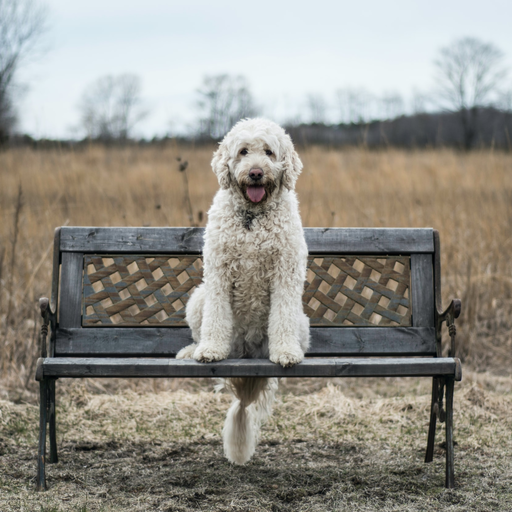

In [18]:
init_image

#内部代码实现。核心是1.从参考的图片初始化噪声。2.强度控制通过timesteps的开始时间进行。0.18215是归一化系数

In [47]:
import numpy as np

# Encode init_image
init_image_tensor = torch.from_numpy(np.array(init_image).transpose(2, 0, 1)).float() / 255.0  # 0~255 => 0~1
init_image_tensor = 2.0 * init_image_tensor - 1.0  # 0~1 => -1~1
init_image_tensor = init_image_tensor.unsqueeze(0).to(device)  # add batch dim.

with torch.no_grad():
    init_image_latents = pipe.vae.encode(init_image_tensor).latent_dist.sample()*pipe.vae.config.scaling_factor

0.18215
tensor([595, 562, 529, 496, 463, 430, 397, 364, 331, 298, 265, 232, 199, 166,
        133, 100,  67,  34,   1], device='cuda:0') tensor([595], device='cuda:0')


/home/jiuxia/libs/python/anaconda3/envs/comfyui/lib/python3.12/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:308: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)


Text(0.5, 1.0, 'Result')

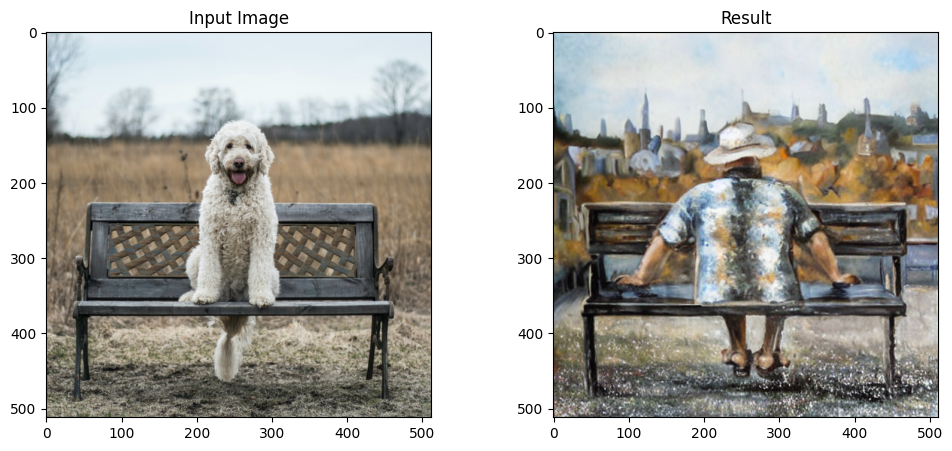

: 

In [49]:
guidance_scale = 7.5
steps = 30
strength = 0.6
prompt = "An oil painting of a man on a bench"  # @param

print(pipe.vae.config.scaling_factor)

text_embeddings = pipe._encode_prompt(prompt, device, 1, True, "")
pipe.scheduler.set_timesteps(steps, device=device)

init_timestep = min(int(steps * strength), steps)
t_start = max(0, steps - init_timestep)
timesteps = pipe.scheduler.timesteps[t_start:]

latent_timestep = timesteps[:1]
print(timesteps, latent_timestep)
noise = torch.randn((1, 4, 64, 64), device=device, generator=torch.Generator(device=device).manual_seed(0))
latents = pipe.scheduler.add_noise(init_image_latents, noise, latent_timestep)

for i, t in enumerate(timesteps):
    latent_model_input = torch.cat([latents]*2)
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
    
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

latents_norm = latents/pipe.vae.config.scaling_factor

with torch.no_grad():
    result_image = pipe.vae.decode(latents_norm).sample

result_image = (result_image / 2 + 0.5).clamp(0, 1).squeeze()
result_image = (result_image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
result_image = Image.fromarray(result_image)

# View the result
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(init_image)
axs[0].set_title("Input Image")
axs[1].imshow(result_image)
axs[1].set_title("Result")

###为什么不一样？？？

Inpaint
核心是：1、对参考图加噪声，2、mask区域作用于latent，取反获取background，然后和latent相加。3、此处的latent重高斯噪声开始，而不是img开始

torch.Size([64, 64])

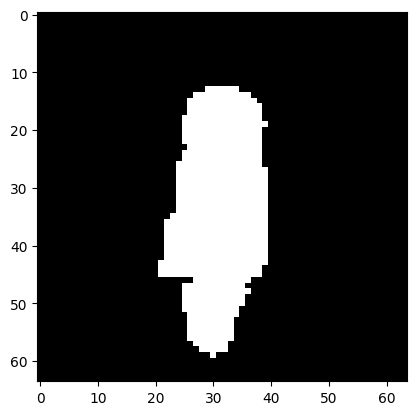

In [45]:
# Resize mask image
mask_image_latent_size = mask_image.resize((64, 64))
mask_image_latent_size = torch.tensor((np.array(mask_image_latent_size)[..., 0] > 5).astype(np.float32))
plt.imshow(mask_image_latent_size.numpy(), cmap="gray")

mask_image_latent_size = mask_image_latent_size.to(device)
mask_image_latent_size.shape

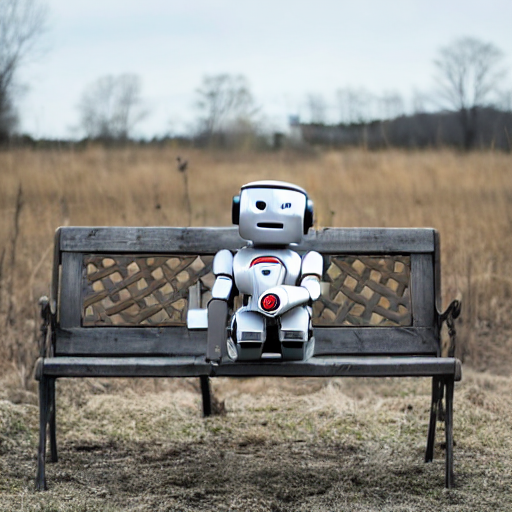

In [46]:
guidance_scale = 8  # @param
num_inference_steps = 30  # @param
prompt = "A small robot, high resolution, sitting on a park bench"
negative_prompt = "zoomed in, blurry, oversaturated, warped"
generator = torch.Generator(device=device).manual_seed(42)

# Encode the prompt
text_embeddings = pipe._encode_prompt(prompt, device, 1, True, negative_prompt)

# Create our random starting point
latents = torch.randn((1, 4, 64, 64), device=device, generator=generator)
latents *= pipe.scheduler.init_noise_sigma

# Prepare the scheduler
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

for i, t in enumerate(pipe.scheduler.timesteps):
    # Expand the latents if we are doing classifier free guidance
    latent_model_input = torch.cat([latents] * 2)

    # Apply any scaling required by the scheduler
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # Predict the noise residual with the UNet
    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # Perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Compute the previous noisy sample x_t -> x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents, return_dict=False)[0]

    # Perform inpainting to fill in the masked areas
    if i < len(pipe.scheduler.timesteps) - 1:
        # Add noise to the original image's latent at the previous timestep t-1
        noise = torch.randn(init_image_latents.shape, generator=generator, device=device, dtype=torch.float32)
        background = pipe.scheduler.add_noise(
            init_image_latents, noise, torch.tensor([pipe.scheduler.timesteps[i + 1]])
        )

        latents = latents * mask_image_latent_size  # white in the areas
        background = background * (1 - mask_image_latent_size)  # black in the areas

        # Combine the generated and original image latents based on the mask
        latents += background

# Decode latents
latents_norm = latents / pipe.vae.config.scaling_factor

with torch.no_grad():
    inpainted_image = pipe.vae.decode(latents_norm).sample

inpainted_image = (inpainted_image / 2 + 0.5).clamp(0, 1).squeeze()
inpainted_image = (inpainted_image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
inpainted_image = Image.fromarray(inpainted_image)

inpainted_image